<a href="https://colab.research.google.com/github/BrianGomora/neuralnetwork/blob/main/Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORT ALL LIBRARIES**

In [ ]:
# Libraries for data visualization and analysis
import pandas as pd
import numpy as n
import matplotlib.pyplot as plt
import os
import random 


# Libraries for deep learning 
import keras
from keras.models import Model, Sequential
from keras.layers.core import Flatten,Dense,Dropout,Activation 
from keras.layers import BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D,ZeroPadding2D
#from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array


import cv2

**MOUNT GOOGLE DRIVE TO ACCESS FOLDER FOR TRAINING DATA**

In [ ]:

from google.colab import drive

drive.mount('/content/gdrive')
folder_path = 'gdrive/My Drive/Emotion/'

Mounted at /content/gdrive


**DISPLAY SOME IMAGES FROM DISGUST FROM TRAINING DATASET**

In [5]:
image_size = 48

expression = "disgust"
plt.style.use("dark_background")
plt.figure(figsize= (12,12))
for i in range(1,10,1):
  plt.subplot(3,3,i)
  img = load_img(folder_path +"trainDATA/" + expression+ "/" + os.listdir(folder_path + "trainDATA/" + expression)[i], target_size=(image_size, image_size))
  plt.imshow(img)
plt.show()

**DISPLAY SOME IAMGES FROM HAPPY TRAINING DATASET**

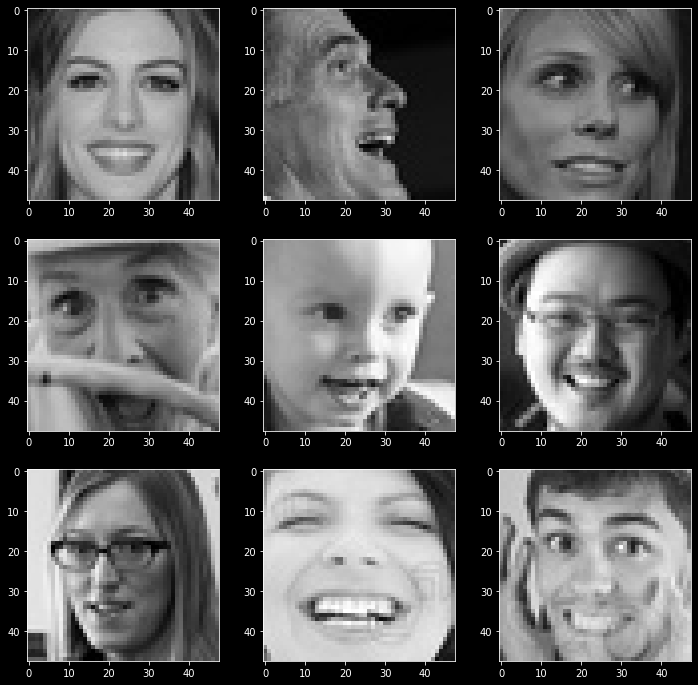

In [ ]:
image_size = 48
folder_path = 'gdrive/My Drive/Emotion/'


expression = "happy"
plt.style.use("dark_background")
plt.figure(figsize= (12,12))
for i in range(1,10,1):
  plt.subplot(3,3,i)
  img = load_img(folder_path +"trainDATA/" + expression+ "/" + os.listdir(folder_path + "trainDATA/" + expression)[i], target_size=(image_size, image_size))
  plt.imshow(img)
plt.show()

**DISPLAY SOME IMAGES FROM NEUTRAL DATASET**

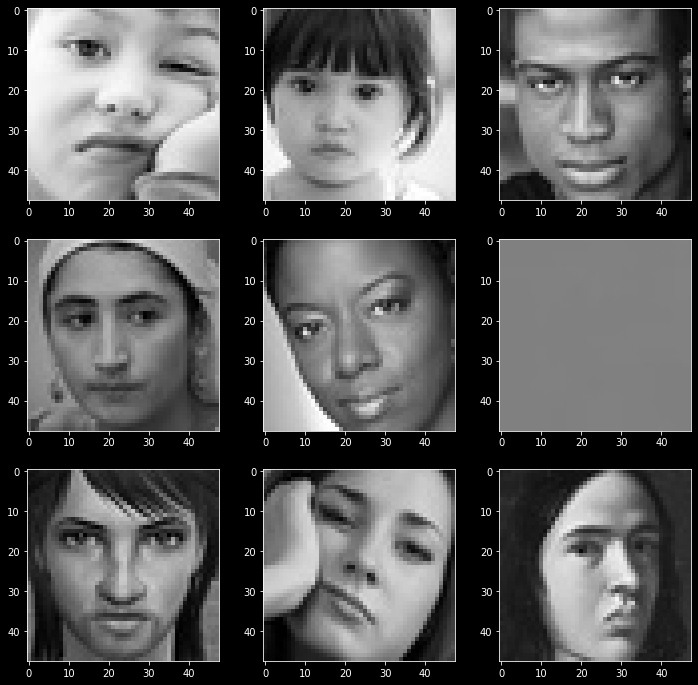

In [ ]:
image_size = 48
folder_path = 'gdrive/My Drive/Emotion/'

expression = "neutral"
plt.style.use("dark_background")
plt.figure(figsize= (12,12))
for i in range(1,10,1):
  plt.subplot(3,3,i)
  img = load_img(folder_path +"trainDATA/" + expression+ "/" + os.listdir(folder_path + "trainDATA/" + expression)[i], target_size=(image_size, image_size))
  plt.imshow(img)
plt.show()

**DATA AUGMENTATION - GENERATING MORE DATA FOR TRAINING for generalization**

In [ ]:
batch_size = 16   #number of images per iteration or 64
image_size = 48


imagedatagen_train = ImageDataGenerator(rescale= 1./255,
                                        rotation_range=30,
                                        shear_range=0.3,
                                        zoom_range=0.3,
                                        horizontal_flip= True,
                                        height_shift_range=0.4,
                                        width_shift_range =0.4)

imagedatagen_val = ImageDataGenerator(horizontal_flip = True)

train_imageSET = imagedatagen_train.flow_from_directory(folder_path + "EtrainDATA",
                                                  target_size = (image_size,image_size),
                                                  color_mode = 'grayscale',
                                                  batch_size = batch_size,
                                                  class_mode = "categorical",
                                                  shuffle = True)

test_imageSET = imagedatagen_val.flow_from_directory(folder_path + "EtestDATA",
                                                  target_size = (image_size,image_size),
                                                  color_mode ='grayscale',
                                                  batch_size = batch_size,
                                                  class_mode = "categorical",
                                                  shuffle = False)

Found 21 images belonging to 7 classes.
Found 21 images belonging to 7 classes.


**BUILDING THE CONVOLUTIONAL NEURAL NETWORK**

In [ ]:
num_classes = 7 
model = Sequential()
random.seed()

#1st CNN layer 
model.add(Convolution2D(254,(3,3),padding ="same", input_shape= (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer 
model.add(Convolution2D(252,(3,3),padding ="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

#3Rd CNN layer 
model.add(Convolution2D(512,(3,3),padding ="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

#4th CNN layer 
model.add(Convolution2D(512,(3,3),padding ="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected 1st  Layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected 2nd  Layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation= 'softmax'))

opt = Adam(lr = 0.2)
model.compile(optimizer = opt,loss='categorical_crossentropy', metrics = ["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

**TRAIN AND VALIDATE WITH CNN MODEL**

In [ ]:
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

epochs = 1000
steps_per_epoch = train_imageSET.n/ train_imageSET.batch_size
validation_steps = test_imageSET.n/ test_imageSET.batch_size



checkpoint = ModelCheckpoint("./model_weights.h5",monitor = "val_loss",
                             save_weights_only = True, mode= 'max',verbose = 1)



reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor = 0.1,patience = 2,min_lr=0.00001,
                              mode='auto')

callback_list = [checkpoint,reduce_lr]

history = model.fit(
    x = train_imageSET,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs, 
    validation_data = test_imageSET,
    validation_steps = validation_steps,
    callbacks = callback_list 
)


Epoch 1/1000
1/1 [==============================] - 42s 35s/step - loss: 3.3852 - accuracy: 0.0000e+00 - val_loss: 6605.3057 - val_accuracy: 0.1429

Epoch 00001: saving model to ./model_weights.h5
Epoch 2/1000
1/1 [==============================] - 0s 476ms/step - loss: 3.3731 - accuracy: 0.1937 - val_loss: 65885.8125 - val_accuracy: 0.1429

Epoch 00002: saving model to ./model_weights.h5
Epoch 3/1000
1/1 [==============================] - 0s 399ms/step - loss: 2.2877 - accuracy: 0.1577 - val_loss: 225056.0000 - val_accuracy: 0.1429

Epoch 00003: saving model to ./model_weights.h5
Epoch 4/1000
1/1 [==============================] - 0s 368ms/step - loss: 2.8816 - accuracy: 0.2421 - val_loss: 132889.2656 - val_accuracy: 0.1429

Epoch 00004: saving model to ./model_weights.h5
Epoch 5/1000
1/1 [==============================] - 0s 458ms/step - loss: 2.7748 - accuracy: 0.1937 - val_loss: 95402.7891 - val_accuracy: 0.1429

Epoch 00005: saving model to ./model_weights.h5
Epoch 6/1000
1/1 [===

**PLOT ACCURACY AND LOSS**

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1,2,2)
plt.subtitle('Optimizer:Adam', fontsize=10)
plt.ylabel('Loss',fontsize=16)
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.ylabel('Accuracy'fontsize = 16)
plt.plot(history.history['accuracy'],label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

**REPRESENT MODEL AS JSON STRING**

In [ ]:
fer_json = model.to_json()
with open('fer.json','w') as json_file:
  json_file.write(fer_json)
model.save_weights('fer.h5')